### import packages

In [56]:
import datascience as ds
from datascience import *
import numpy as np
from graphviz import Source
import pandas as pd
import re, string
import nltk
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier as XGBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

%matplotlib inline

In [57]:
def process_text(data):
    cleaned_text = [
        re.sub('\s+', ' ', re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|[0-9]+|http.+?", '',
               tweets.lower()).strip(string.punctuation).strip()) for tweets in data
        ]
    return cleaned_text

In [58]:
tagged = pd.read_csv('tagged.csv', sep=',', index_col=False)
tagged.text = process_text(tagged.text)
tagged = tagged.drop(tagged.columns[0], axis=1).reset_index(drop=True)
tagged = tagged.drop(tagged[tagged.sentiment==-1].index).reset_index(drop=True)
tagged = tagged.iloc[tagged.text.drop_duplicates().index]
tagged.to_csv('relevant_tagged.csv')

### tweets data loaded into Jupyter Notebook as Table object

In [59]:
df = ds.Table.read_table('relevant_tagged.csv', sep=',')
df

Unnamed: 0,user_id,user_name,tweet_time,location,text,sentiment
0,802657195661742080,Christine Warren,Wed Sep 12 01:38:14 +0000 2018,Fremont CA,american lives were just lost in tennessee potus please ...,0
1,1039245812230893570,Trumpservative,Wed Sep 12 01:38:16 +0000 2018,Tulsa OK,farmacist our great leader president donald j trump can ...,1
2,282084840,Darrel Sheldon #MAGAVETERAN,Wed Sep 12 01:38:18 +0000 2018,None,rev out the trumptrain for fa,0
3,62315639,Queer Liberal Voting Snowflake,Wed Sep 12 01:38:18 +0000 2018,Big Sandy Texas,tennessee is suffering after shooting takes lives potus ...,0
4,340428574,DelcoGal,Wed Sep 12 01:38:21 +0000 2018,Pennsylvania,redwaverising this years midterm is the most important i ...,1
5,1603928228,Julz,Wed Sep 12 01:38:22 +0000 2018,MIAATLPGH,lives were just lost in tennessee potus its time to do s ...,0
6,1865678516,Barbara Kuczinski,Wed Sep 12 01:38:22 +0000 2018,None,oh hon cnn reports the truth as fast as they can dream i ...,1
7,59288409,Josh Steed PhD,Wed Sep 12 01:38:25 +0000 2018,Arkansas,msm is repulsive they do nothing but lie and undermine p ...,0
8,325172419,Mrs. Linz,Wed Sep 12 01:38:25 +0000 2018,BC Canada,muslims coming illegally across the southern border maga ...,2
9,2283127514,Garrett ODowd,Wed Sep 12 01:38:26 +0000 2018,Melbourne Victoria,when you find out donald trump isnt coming to ireland se ...,1


### data preprocessing

### StratifiedKFold

In [60]:
X = list(df['text'])
y = list(df['sentiment'])

#### Check whether the data distribution is balanced

In [61]:
def check(sentiment, index, note='training'):
    if sentiment==0:
        label = 'neutral'
    elif sentiment==1:
        label = 'positive'
    else:
        label = 'negative'
    print('There are {} '.format(df.take(index).where('sentiment', are.equal_to(sentiment)).size[0][0])+label+' tweets in the '+note+' set.')

#### Model Building

In [62]:
def custom_split(train_index, test_index):
    trainingset = df.take(train_index)
    testingset = df.take(test_index)    
        
    X_train= list(trainingset['text'])
    y_train= list(trainingset['sentiment'])
    X_test= list(testingset['text'])
    y_test= list(testingset['sentiment'])
    
    return X_train, X_test, y_train, y_test

In [63]:
def word_vectorizer(X_train, X_test):
    vect = CountVectorizer(
         analyzer="word", ngram_range=([1,2]), tokenizer=nltk.word_tokenize,
        preprocessor=None, stop_words='english', max_features=3000)
#     vect = TfidfVectorizer(sublinear_tf=True, min_df=10, norm='l1', encoding='latin-1', 
#                             ngram_range=(1,2), stop_words='english')
    X_train_vect = vect.fit_transform(X_train).todense()
    X_test_vect = vect.transform(X_test)
    return X_train_vect, X_test_vect, vect.get_feature_names()

In [88]:
def classifier(X_train, y_train, X_test, fold, feature_names):
    clf = DecisionTreeClassifier(criterion = 'entropy',
                                    random_state = 100,
                                    max_depth = 5,
                                    min_samples_leaf = 2)
#     clf = RandomForestClassifier(random_state=100,
#                                  n_estimators=20, 
#                                  criterion='entropy', 
#                                  n_jobs=4)
#     clf = XGBoostClassifier(max_depth=5, n_estimators=5)
    clf.fit(X_train, y_train)
    try:
        dot_data = tree.export_graphviz(clf, out_file=None, feature_names=feature_names)
        graph = Source(dot_data)
        graph.render('SentientClassifier-Fold_{}'.format(fold))
    except Exception as e:
        print(e)
    predicted_y_test = clf.predict(X_test)
    return predicted_y_test

In [89]:
def eval_results(predicted_y_test, y_test):
    print('\n Testing precision are: ', predicted_y_test, '\n')
    precision_s = precision_score(y_test, predicted_y_test, average='weighted')
    recall_s = recall_score(y_test, predicted_y_test, average='weighted')
    f1_s = f1_score(y_test, predicted_y_test, average='weighted')
    cm = confusion_matrix(y_test, predicted_y_test)  

    print("Precision Score:", precision_s)
    print("Recall Score:", recall_s)
    print("f1 Score:", f1_s)
    print('confusion_matrix is: \n', cm, '\n')
    return precision_s, recall_s, f1_s, cm

In [90]:
def k_fold_evaluate(X, y, n_splits):
    # initialization
    fold = 1
    accuracy_ = []
    precision = []
    recall=[]
    f1 = []
    skf = StratifiedKFold(n_splits=n_splits, random_state=1, shuffle= True)

    # build model and collect results
    for train_index, test_index in skf.split(X, y):
        if fold==1:
            list(map(lambda x: check(x, train_index), range(3)))
            list(map(lambda x: check(x, test_index, note='testing'), range(3)))
        
        X_train, X_test, y_train, y_test = custom_split(train_index, test_index)
        
        X_train_vect, X_test_vect, feature_names = word_vectorizer(X_train, X_test)
        predicted_y_test = classifier(X_train=X_train_vect, y_train=y_train, X_test=X_test_vect, fold=fold, feature_names=feature_names)
        precision_s, recall_s, f1_s, cm = eval_results(predicted_y_test, y_test)
        
        precision.append(precision_s)
        recall.append(recall_s)
        f1.append(f1_s)
        
        sns.heatmap(cm, annot=True, cmap='Blues')
        plt.show()
        
        fold += 1
    
    metrics_df = pd.DataFrame(
        {'precision': precision,
        'recall':recall,
        'f1':f1}
    )
    print(metrics_df)
    metrics_df.plot(linewidth=2)

/usr/local/lib/python3.6/dist-packages/datascience/tables.py:192: FutureWarning: Implicit column method lookup is deprecated.
  warnings.warn("Implicit column method lookup is deprecated.", FutureWarning)


There are 313 neutral tweets in the training set.
There are 308 positive tweets in the training set.
There are 188 negative tweets in the training set.
There are 79 neutral tweets in the testing set.
There are 77 positive tweets in the testing set.
There are 47 negative tweets in the testing set.

 Testing precision are:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0
 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 2 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 

Precision Score: 0.7709616174055828
Recall Score: 0.4433497536945813
f1 Score: 0.32625631649925796
confusion_matrix is: 
 [[79  0  0]
 [71  6  0]
 [42  0  5]] 



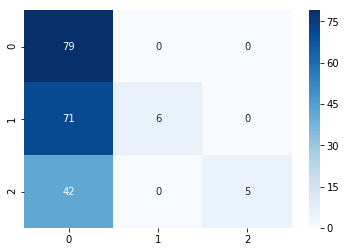


 Testing precision are:  [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 2 0 0 0 0 0 0 0 1 0 0 0] 

Precision Score: 0.7717999638923994
Recall Score: 0.4482758620689655
f1 Score: 0.3354497354497354
confusion_matrix is: 
 [[79  0  0]
 [69  8  0]
 [43  0  4]] 



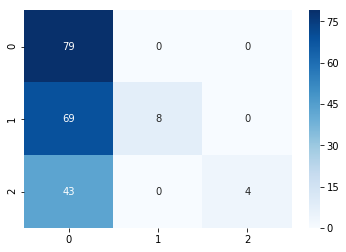


 Testing precision are:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0
 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 2 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0
 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0] 

Precision Score: 0.7150518623290901
Recall Score: 0.44554455445544555
f1 Score: 0.33276596308088363
confusion_matrix is: 
 [[78  0  0]
 [67  9  1]
 [44  0  3]] 



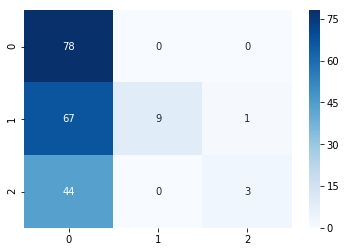


 Testing precision are:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0] 

Precision Score: 0.7740678323151464
Recall Score: 0.45544554455445546
f1 Score: 0.3482432699997694
confusion_matrix is: 
 [[78  0  0]
 [65 12  0]
 [45  0  2]] 



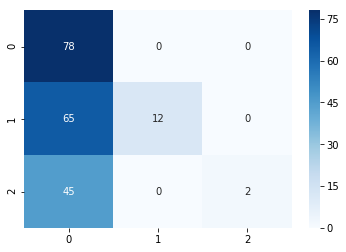


 Testing precision are:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 2 0 0 1 0 1 0 0 0 0 0 0 2 0 0 0 0 0 0 0 2 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 2 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 

Precision Score: 0.6502272358383379
Recall Score: 0.4603960396039604
f1 Score: 0.3587467500065656
confusion_matrix is: 
 [[78  0  0]
 [65 11  1]
 [40  3  4]] 



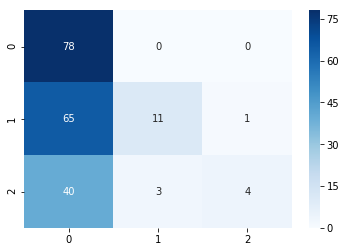

   precision    recall        f1
0   0.770962  0.443350  0.326256
1   0.771800  0.448276  0.335450
2   0.715052  0.445545  0.332766
3   0.774068  0.455446  0.348243
4   0.650227  0.460396  0.358747


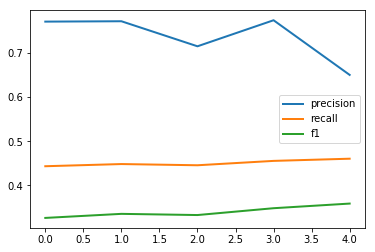

In [91]:
k_fold_evaluate(X, y, n_splits=5)

### Explore other classifiers

In [68]:
vect = CountVectorizer(
         analyzer="word", ngram_range=([1,2]), tokenizer=nltk.word_tokenize,
        preprocessor=None, stop_words='english', max_features=3000)
X_vect = vect.fit_transform(tagged.text).todense()
y = tagged.sentiment

In [69]:
def compare_classifiers(models, X, y):
    CV = 5
    cv_df = pd.DataFrame(index=range(CV * len(models)))
    entries = []
    for model in models:
        model_name = model.__class__.__name__
        accuracies = cross_val_score(model, X, y, scoring='accuracy', cv=CV)
        for fold_idx, accuracy in enumerate(accuracies):
            entries.append((model_name, fold_idx, accuracy))
    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
    plt.figure(figsize=(8,8))
    sns.boxplot(x='model_name', y='accuracy', data=cv_df)
    sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
    plt.xticks(rotation=90)
    plt.show()
    

In [ ]:
models = [
    DecisionTreeClassifier(criterion = 'entropy',
                                    random_state = 100,
                                    max_depth = 15,
                                    min_samples_leaf = 2),
    RandomForestClassifier(random_state=100,
                                 n_estimators=15, 
                                 criterion='entropy', 
                                 n_jobs=4),
    XGBoostClassifier(max_depth=8, n_estimators=5),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    GradientBoostingClassifier(),
    AdaBoostClassifier(n_estimators=100, learning_rate=0.1),
]
compare_classifiers(models, X_vect, y)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi